# Import the libraries

In [60]:
#import libraries

import numpy as np
import matplotlib.pyplot as plt
import os
from numba import jit
import timeit
from interpolation.splines import LinearSpline, CubicSpline
import h5py as h5
from scipy import constants as const
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.misc import derivative
import matplotlib
#%matplotlib inline


#  electrode numbers are:
#   0  -> f1 under (195V)
#   1  -> f4 under (195V)
#   2  -> f1 above (-145V)
#   3  -> f4 above (-232V)
#   4  -> MCP cage (-0.114V)
#   5  -> MCP out (-1900V)
#   6  -> Chamber (0V)
#   7  -> CEM cage (4V)
#   8  -> deflection ring 1 (0.3V)
#   9  -> deflection ring 2 (-232V)
#   10 -> f2 under (195V)
#   11 -> f3 under (195V)
#   12 -> f2 above (-145V)
#   13 -> f3 above (-232V)
#   14-18 -> read out electrodes/cables (0V)

#x_grid = np.array(potential_file["Coordinates/X"].value / 2.)
#y_grid = np.array(potential_file["Coordinates/Y"].value / 2.)
#z_grid = np.array(potential_file["Coordinates/Z"].value / 2.)

In [ ]:
import xarray as xr
import pandas as pd

# 1. Get electrode shape and grid

In [62]:
potential_file = h5.File('PA_v4.hdf5', 'r')
coors = [potential_file['Coordinates/' + i][()] / 2. for i in 'XYZ']

coors is a 3 array with inhomogenous lengths  
data points in coors

x $\rightarrow$121

y$\rightarrow$121

z$\rightarrow$173

In [63]:
electrodes = xr.Dataset({
    'electrode' + str(i): 
    xr.DataArray(potential_file['Potential Arrays/electrode' + str(i)][()]/10000, coords=coors, dims=['x', 'y', 'z']) 
    for i in np.arange(1, 19)})
potential_file.close()

In [64]:
print(np.shape(np.array(electrodes.electrode1)))

(121, 121, 173)


# 2. Define Potential Function

In [65]:
def potential(f1_under,f2_under,f3_under,f4_under,
              f1_above,f2_above,f3_above,f4_above,
              MCP_cage,MCP_out,CEM_cage,deflection_ring_1,deflection_ring_2):
    pre_potential = np.array(electrodes.electrode1)*f1_under
    pre_potential += np.array(electrodes.electrode2)*f4_under
    pre_potential += np.array(electrodes.electrode3)*f1_above
    pre_potential += np.array(electrodes.electrode4)*f4_above
    pre_potential += np.array(electrodes.electrode5)*MCP_cage
    pre_potential += np.array(electrodes.electrode6)*MCP_out
    pre_potential += np.array(electrodes.electrode8)*CEM_cage
    pre_potential += np.array(electrodes.electrode9)*deflection_ring_1
    pre_potential += np.array(electrodes.electrode10)*deflection_ring_2
    pre_potential += np.array(electrodes.electrode11)*f2_under
    pre_potential += np.array(electrodes.electrode12)*f3_under
    pre_potential += np.array(electrodes.electrode13)*f2_above
    pre_potential += np.array(electrodes.electrode14)*f3_above
    return pre_potential

# 3. The coordinates of the electrodes

In [66]:
radius_inner=15 #mm
center=[102.5,102.5] # x,y
data_points=100
electrode_coords_inner=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_inner[i]= np.cos(theta)*radius_inner +center[0],np.sin(theta)*radius_inner +center[1]
radius_outer=20 #mm
#center=[102.5,102.5] # x,y
electrode_coords_outer=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_outer[i]= np.cos(theta)*radius_outer +center[0],np.sin(theta)*radius_outer +center[1]
radius_outer_up=17.5
electrode_coords_outer_up=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_outer_up[i]= np.cos(theta)*radius_outer_up +center[0],np.sin(theta)*radius_outer_up +center[1]

In [67]:
#old_potential = potential(195,195,195,195,-145,-145,-232,-232,-0.114,-1900,4,0.3,-232)

#print(np.shape(old_potential))

const_E_in_x = 17.76*potential(0,1,0,-1,0,1,0,-1,0,0,0,0,0) #field z
new_potential = const_E_in_x#26.16*potential(-1,1,-1,1,-1,1,-1,1,0,0,0,0,0)+const_E_in_x

#new_potential = const_E_in_x#+26*potential(1,-1,1,-1,1,-1,1,-1,0,0,0,0,0)
# Find E Field in units of V/cm  
#e_field = -1*np.gradient(new_potential, 0.05) 
# potential was given in discrete steps of 0.5 mm, therefore 0.5mm = 0.05cm, therefore 0.05
# x componenet of E field
e_field_x = -1*np.gradient(new_potential, 0.05, axis=0)
# y componenet of E field
e_field_y = -1*np.gradient(new_potential, 0.05, axis=1)
# z componenet of E field
e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)

# magnitude of electric field
abs_e_field = np.sqrt(e_field_x**2+e_field_y**2+e_field_z**2)
#pot_in_xy_plane=np.zeros()
z_coord=51
#for i_x in range(len(electrodes.x)):
 #   for i_y in range(len(electrodes.y)):
  #      pot_in_xy_plane[i_x][i_y]=new_potential[i_x,i_y,z_coord]
pot_in_xy_plane=new_potential[:,:,z_coord]
skip=6
 #index (in middle of the two elctrode planes)
e_x=e_field_x[::skip,::skip,z_coord]
e_y=e_field_y[::skip,::skip,z_coord]
x=electrodes.x[::skip]
y=electrodes.y[::skip]



In [12]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('normal')



In [59]:
off=26.16*np.array((-1,1,-1,1,-1,1,-1,1,0,0,0,0,0))
grad=17.76*np.array((0,1,0,-1,0,1,0,-1,0,0,0,0,0))
off+grad

array([-26.16,  43.92, -26.16,   8.4 , -26.16,  43.92, -26.16,   8.4 ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ])

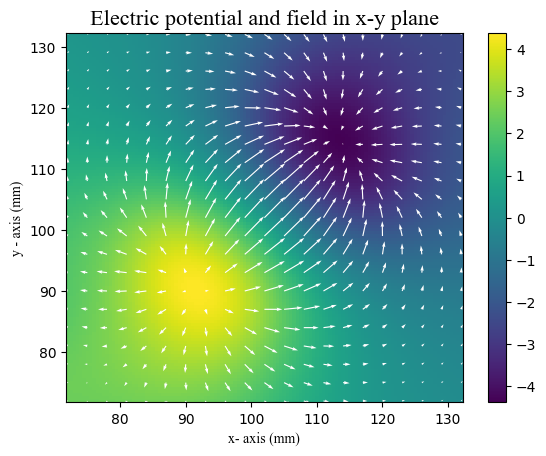

In [68]:
# Program to plot 2-D Heat map
# using matplotlib.pyplot.imshow() method
import numpy as np
import matplotlib.pyplot as plt
 
#data = np.random.random((12, 12))
#plt.pcolormesh(pot_in_xy_plane[:,:])#, cmap='viridis')
pcm=plt.pcolormesh(electrodes.x,electrodes.y,np.transpose(pot_in_xy_plane), norm=matplotlib.colors.CenteredNorm(),cmap='viridis')

#colorbar=plt.colorbar(pc)
#colorbar.set_label("Potential (V)")
#plt.pcolormesh(electrodes.y,electrodes.x,pot_in_xy_plane[:,:])#, cmap='viridis')
#plt.title(f"Electric potential and field \n at z={float(electrodes.z[z_coord])-float(electrodes.z[0])}mm from bottom")
#plt.plot(electrode_coords[:,0],electrode_coords[:,1],'orange')
plt.quiver(x,y,np.transpose(e_x),np.transpose(e_y),scale=None,color='white')
#plt.plot(electrode_coords_outer[:,0],electrode_coords_outer[:,1],'black',marker='.',label='effective electrode ring')

#plt.plot(electrode_coords_inner[:,0],electrode_coords_inner[:,1],'grey',marker='.')
#plt.axvline(x=52)
#plt.axvline(x=51,color='k')
#plt.xlim(5,100)
#plt.axvline(x=31)
#plt.axhline(y=62)
plt.ylabel("y - axis (mm)",fontproperties=font)
plt.xlabel("x- axis (mm)",fontproperties=font)
#plt.legend()
plt.colorbar(pcm)
plt.title("Electric potential and field in x-y plane",fontproperties=font,fontsize=16)
plt.savefig("const_E_vectors.png")
plt.show()

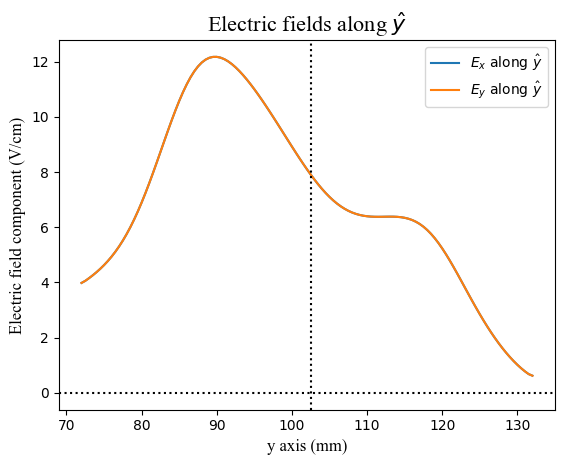

In [14]:
# E_x along y

plt.plot(electrodes.y,abs_e_field[51,:,61],label="$E_{x}$ along $\hat y$")
plt.plot(electrodes.y,abs_e_field[51,:,61],label="$E_{y}$ along $\hat y$")
plt.axvline(x=102.5,linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("y axis (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Electric fields along $\hat y$",fontproperties=font,fontsize=16)
plt.legend()

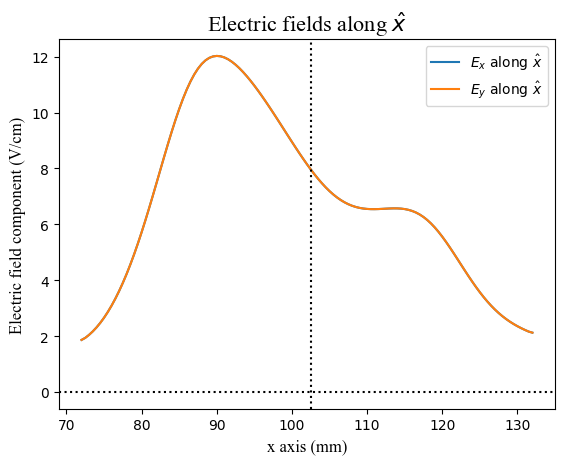

In [15]:
# E_x along y

plt.plot(electrodes.x,abs_e_field[:,51,61],label="$E_{x}$ along $\hat x$")
plt.plot(electrodes.x,abs_e_field[:,51,61],label="$E_{y}$ along $\hat x$")
plt.axvline(x=102.5,linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("x axis (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Electric fields along $\hat x$",fontproperties=font,fontsize=16)
plt.legend()

In [69]:
const_potentials=np.linspace(5,50,50)
e_along_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))    
e_perp_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))    
e_grad_along_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))
e_grad_perp_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))

for index in range(len(const_potentials)):
    print(int((index+1)/50*100),'%',end='\r')
    const_E_in_x_iter = const_potentials[index]*potential(1,-1,1,-1,1,-1,1,-1,0,0,0,0,0) #field z
    new_potential_iter = const_E_in_x_iter#+40*potential(1,0,1,0,0,-1,0,-1,0,0,0,0,0)
    e_field_x_iter = -1*np.gradient(new_potential_iter, 0.05, axis=0)
    e_field_y_iter = -1*np.gradient(new_potential_iter, 0.05, axis=1)
    e_field_z_iter = -1*np.gradient(new_potential_iter, 0.05, axis=2)
    #pot_in_xy_plane=np.zeros()
    z_coord_iter=51
    #pot_in_xy_plane_iter=new_potential_iter[:,:,z_coord_iter]
    
 #index (in middle of the two elctrode planes)
#e_x=e_field_x[::skip,::skip,z_coord]
#e_y=e_field_y[::skip,::skip,z_coord]
#x=electrodes.x[::skip]
#y=electrodes.y[::skip]
    theta_line_with_x_iter = np.pi/4
    e_field_along_chosen_line_iter=np.cos(theta_line_with_x_iter)*e_field_x_iter + np.sin(theta_line_with_x_iter)*e_field_y_iter 
    e_field_perp_chosen_line_iter=np.cos(-theta_line_with_x_iter)*e_field_x_iter + np.sin(-theta_line_with_x_iter)*e_field_y_iter    
    
    e_minus_45_iter=field_along_theta(e_field_x[:,:,z_coord],e_field_y[:,:,z_coord],-np.pi/4)
    e_plus_45_iter=field_along_theta(e_field_x[:,:,z_coord],e_field_y[:,:,z_coord],np.pi/4)
    
    e_minus_45_along_d_prime=np.zeros(shape=(len(electrodes.x)))
    for i in range(0,len(electrodes.x)):
        e_minus_45_along_d_prime[i]=(e_minus_45[i][i])
        
        
    e_minus_45_along_d=np.zeros(shape=(len(electrodes.x)-2))
    for i in range(2,len(electrodes.x)):    
        e_minus_45_along_d[i-2]=(e_mag_minus_45[i][len(electrodes.x)+1-i])
    if (len(electrodes.x)-1-i == i):
        print(i)
    e_plus_45_along_d=np.zeros(shape=(len(electrodes.x)-2))
    for i in range(2,len(electrodes.x)):
        e_plus_45_along_d[i-2]=(e_mag_plus_45[i][len(electrodes.x)+1-i])
    
    e_plus_45_along_d_prime=np.zeros(shape=(len(electrodes.x)))
    for i in range(0,len(electrodes.x)):
        e_plus_45_along_d_prime[i]=(e_plus_45[i][i])
    
    for i in range(len(electrodes.x)):
        e_along_line_iter[index][i]=e_field_along_chosen_line_iter[i,i,z_coord_iter]
    
    for i in range(len(electrodes.x)):
        e_perp_line_iter[index][i]=e_field_perp_chosen_line_iter[i,120-i,z_coord_iter]
    #print(np.shape(e_along_line[index][:]))
    e_grad_along_line_iter[index]=np.gradient(e_along_line_iter[index][:],np.sqrt(2)*0.05,axis=0)
    e_grad_perp_line_iter[index]=np.gradient(e_perp_line_iter[index][:],np.sqrt(2)*0.05,axis=0)
    np.gradient(e_minus_45_along_d_prime,0.05*np.sqrt(2))[60]
    


NameError: name 'e_mag_minus_45' is not defined

In [17]:
def line(x,m,c):
    return m*x+c

In [18]:
m_c,_=curve_fit(line,const_potentials,e_grad_along_line_iter[:,60])

In [181]:
E_required=6
V_required=(E_required-m_c[1])/m_c[0]
print(V_required)

26.164933195838522


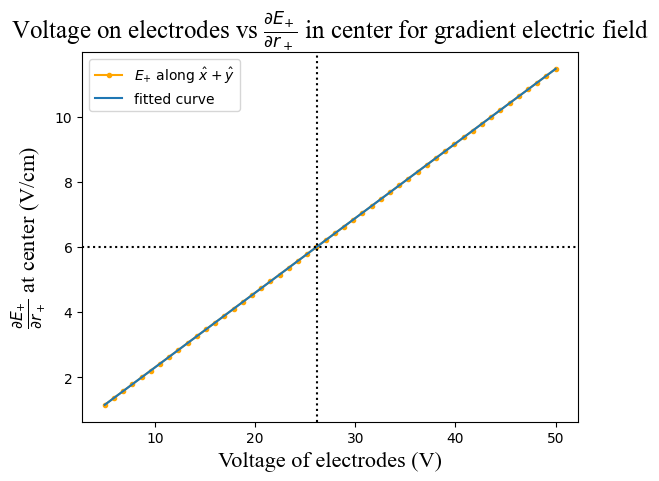

In [184]:
plt.plot(const_potentials,e_grad_along_line_iter[:,60],label=r"$E_{+}$ along $\hat x + \hat y$",color='orange',marker='.')
plt.plot(const_potentials,const_potentials*m_c[0]+m_c[1],label='fitted curve')
#plt.plot(const_potentials,e_perp_line_iter[:,61],'r',label='$E_{d}$ perp to diagonal')
plt.title(r"Voltage on electrodes vs $\frac{\partial E_{+}}{\partial r_+ }$ in center for gradient electric field",fontproperties=font,fontsize=18)
plt.xlabel("Voltage of electrodes (V)",fontproperties=font,fontsize=16)
plt.ylabel(r"$\frac{\partial E_{+}}{\partial r_+ }$ at center (V/cm)",fontproperties=font,fontsize=16)
plt.legend()
plt.axvline(x=V_required,linestyle='dotted',color='k')
plt.axhline(y=E_required,linestyle='dotted',color='k')
plt.show()

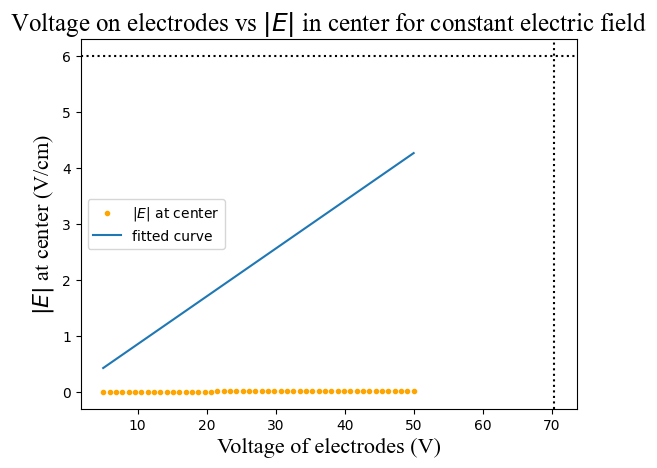

In [157]:
plt.scatter(const_potentials,e_absolute_at_center[:,61],label=r"$|E|$ at center",color='orange',marker='.')
plt.plot(const_potentials,const_potentials*m_c[0]+m_c[1],label='fitted curve')
#plt.plot(const_potentials,e_perp_line_iter[:,61],'r',label='$E_{d}$ perp to diagonal')
plt.title(r"Voltage on electrodes vs $|E|$ in center for constant electric field",fontproperties=font,fontsize=18)
plt.xlabel("Voltage of electrodes (V)",fontproperties=font,fontsize=16)
plt.ylabel(r"$|E|$ at center (V/cm)",fontproperties=font,fontsize=16)
plt.legend()
plt.axvline(x=V_required,linestyle='dotted',color='k')
plt.axhline(y=E_required,linestyle='dotted',color='k')

#plt.axvline(x=V_required,linestyle='dotted',color='k')
#plt.axhline(y=E_required,linestyle='dotted',color='k')
plt.show()

In [19]:
def field_along_theta(Ex,Ey,theta):
    # first coordinate is x, second is y for both ex and ey
           
    return Ex*np.cos(theta) + Ey*np.sin(theta)
        
    

In [75]:
e_minus_45=field_along_theta(e_field_x[:,:,z_coord],e_field_y[:,:,z_coord],-np.pi/4)
e_plus_45=field_along_theta(e_field_x[:,:,z_coord],e_field_y[:,:,z_coord],np.pi/4)

In [76]:
e_minus_45_along_d=np.zeros(shape=(len(electrodes.x)-2))
for i in range(2,len(electrodes.x)):    
    e_minus_45_along_d[i-2]=(e_minus_45[i][len(electrodes.x)+1-i])
    if (len(electrodes.x)-1-i == i):
        print(i)
e_plus_45_along_d=np.zeros(shape=(len(electrodes.x)-2))
for i in range(2,len(electrodes.x)):
    e_plus_45_along_d[i-2]=(e_plus_45[i][len(electrodes.x)+1-i])

60


In [77]:
e_mag_minus=np.zeros(shape=(len(electrodes.x)-2))
for i in range(2,len(electrodes.x)):    
    e_mag_minus[i-2]=(abs_e_field[i][len(electrodes.x)+1-i][z_coord])
    if (len(electrodes.x)+1-i == i):
        print(i)
e_mag_plus=np.zeros(shape=(len(electrodes.x)))
for i in range(0,len(electrodes.x)):
    e_mag_plus[i]=(abs_e_field[i][i][z_coord])


61


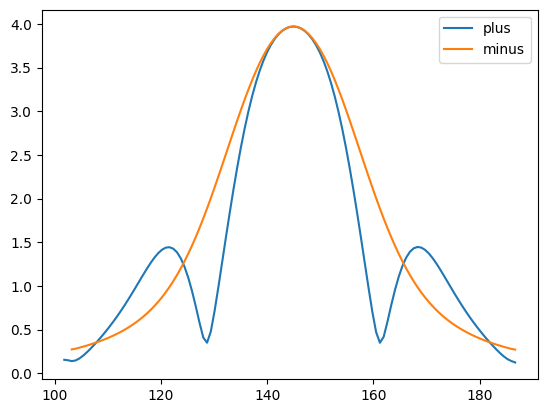

In [78]:
plt.plot(electrodes.x*np.sqrt(2),e_mag_plus,label='plus')
plt.plot(electrodes.x[2:]*np.sqrt(2),e_mag_minus,label='minus')
plt.legend()

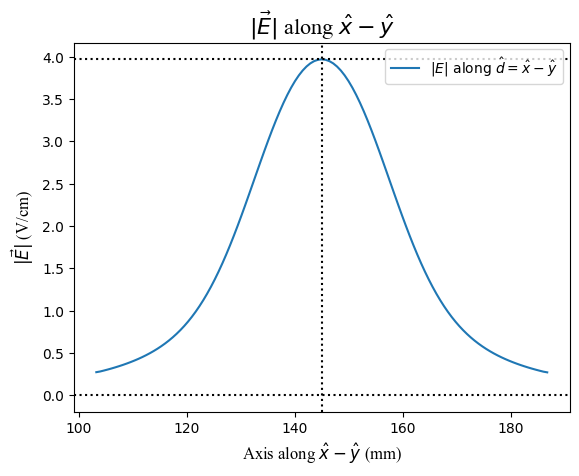

In [79]:
plt.plot(electrodes.x[2:]*np.sqrt(2),e_mag_minus,label=r'$|E|$ along $\hat d= \hat x - \hat y$')
#plt.plot(electrodes.x*np.sqrt(2),e_minus_plus,0.05*np.sqrt(2),label=r'$$')
#plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_mag_minus,0.05*np.sqrt(2)),label='minus')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axhline(y=3.97,linestyle='dotted',color='k')

plt.xlabel("Axis along $\hat x - \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel(r"$|\vec{E}|$ (V/cm)",fontproperties=font,fontsize=12)
plt.title(r"$|\vec{E}|$ along $\hat x - \hat y$",fontproperties=font,fontsize=16)

plt.legend()

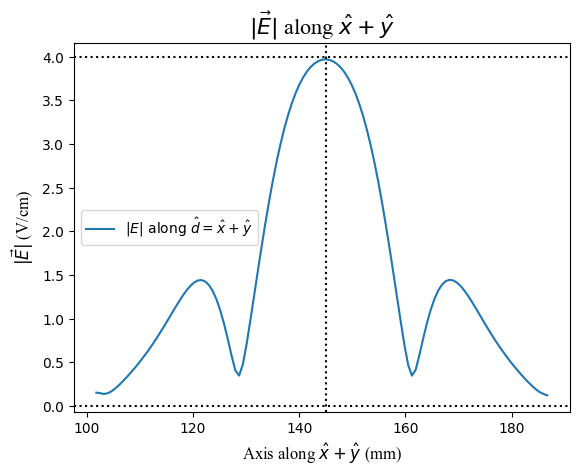

In [80]:
plt.plot(electrodes.x*np.sqrt(2),e_mag_plus,label=r'$|E|$ along $\hat d= \hat x + \hat y$')
#plt.plot(electrodes.x*np.sqrt(2),e_minus_plus,0.05*np.sqrt(2),label=r'$$')
#plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_mag_minus,0.05*np.sqrt(2)),label='minus')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axhline(y=4,linestyle='dotted',color='k')

plt.xlabel("Axis along $\hat x + \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel(r"$|\vec{E}|$ (V/cm)",fontproperties=font,fontsize=12)
plt.title(r"$|\vec{E}|$ along $\hat x + \hat y$",fontproperties=font,fontsize=16)

plt.legend()

Text(0.5, 1.0, '$\\frac{\\partial |\\vec{E}| }{\\partial d_{+}}$ along $\\hat x + \\hat y$')

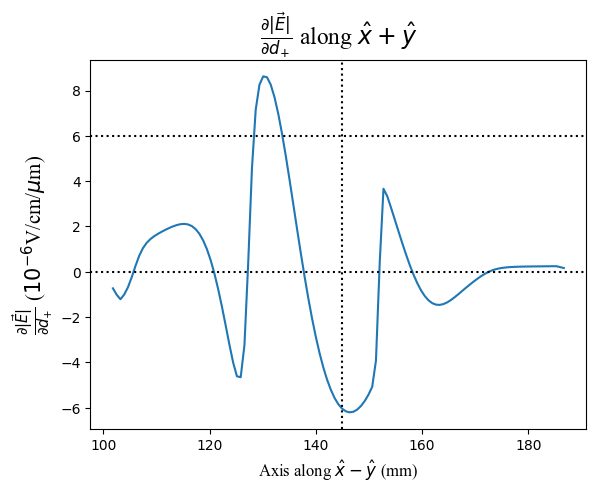

In [44]:
plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_mag_plus,0.05*np.sqrt(2)),label=r'$\frac{\partial |\vec{E}| }{\partial d_{\plus}}$ along $\hat d= \hat x + \hat y$')
#plt.plot(electrodes.x*np.sqrt(2),e_minus_plus,0.05*np.sqrt(2),label=r'$$')
#plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_mag_minus,0.05*np.sqrt(2)),label='minus')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axhline(y=6,linestyle='dotted',color='k')

plt.xlabel("Axis along $\hat x - \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel(r"$\frac{\partial |\vec{E}| }{\partial d_{+}} $ ($10^{-6}$V/cm/$\mu$m)",fontproperties=font,fontsize=15)
plt.title(r"$\frac{\partial |\vec{E}| }{\partial d_{+}}$ along $\hat x + \hat y$",fontproperties=font,fontsize=17)

#plt.legend()

Text(0.5, 1.0, '$\\frac{\\partial |\\vec{E}| }{\\partial d_{-}}$ along $\\hat x - \\hat y$')

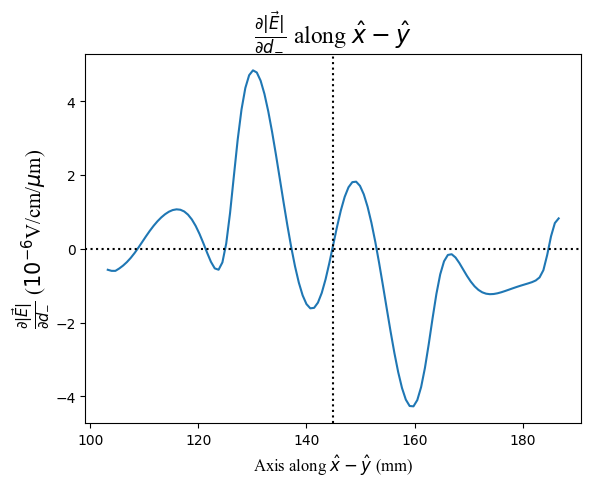

In [45]:
plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_mag_minus,0.05*np.sqrt(2)),label=r'$\frac{\partial |\vec{E}| }{\partial d_{\minus}}$ along $\hat d= \hat x - \hat y$')
#plt.plot(electrodes.x*np.sqrt(2),e_minus_plus,0.05*np.sqrt(2),label=r'$$')
#plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_mag_minus,0.05*np.sqrt(2)),label='minus')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
#plt.axhline(y=6,linestyle='dotted',color='k')

plt.xlabel("Axis along $\hat x - \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel(r"$\frac{\partial |\vec{E}| }{\partial d_{-}} $ ($10^{-6}$V/cm/$\mu$m)",fontproperties=font,fontsize=15)
plt.title(r"$\frac{\partial |\vec{E}| }{\partial d_{-}}$ along $\hat x - \hat y$",fontproperties=font,fontsize=17)

#plt.legend()

In [46]:
e_plus_45_along_d[60]#-e_field_x[60,60,z_coord]*np.cos(-np.pi/4)+e_field_y[60,60,z_coord]*np.sin(-np.pi/4)

3.980664852034807

In [48]:
(e_field_x[61,61,51]*np.cos(np.pi/4)+e_field_y[61,61,51]*np.sin(np.pi/4))

3.9762542446885587

In [49]:
(e_field_x[61,61,51]*np.cos(np.pi/4)+e_field_y[61,61,51]*np.sin(np.pi/4))

3.9762542446885587

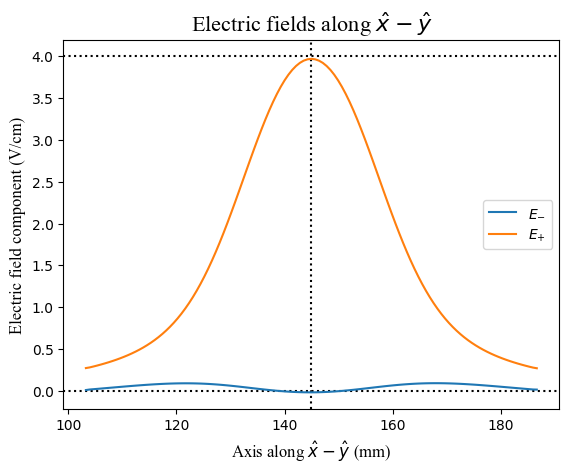

In [91]:

plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axhline(y=4,linestyle='dotted',color='k')
plt.xlabel("Axis along $\hat x - \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Electric fields along $\hat x - \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.x[2:]*np.sqrt(2),e_minus_45_along_d,label=r'$E_{\minus}$')
plt.plot(electrodes.x[2:]*np.sqrt(2),e_plus_45_along_d,label=r'$E_{\plus}$ ')
plt.legend()

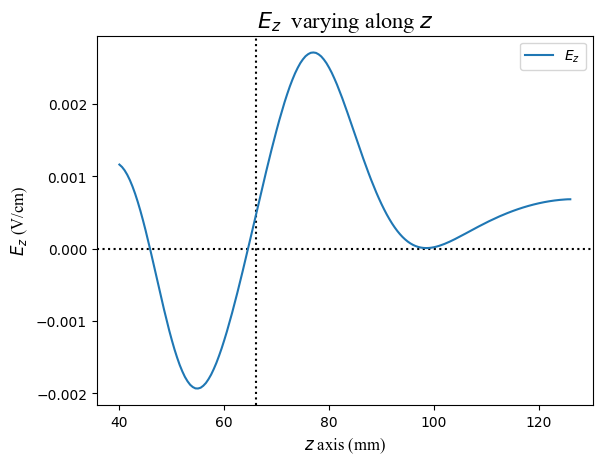

In [82]:
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axvline(x=66,linestyle='dotted',color='k')
#plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("$z$ axis (mm)",fontproperties=font,fontsize=12)
plt.ylabel("$E_z$ (V/cm)",fontproperties=font,fontsize=12)
plt.title("$E_z$  varying along $z$",fontproperties=font,fontsize=16)


plt.plot(electrodes.z,e_field_z[61,61,:],label=r'$E_{z}$')
plt.legend()

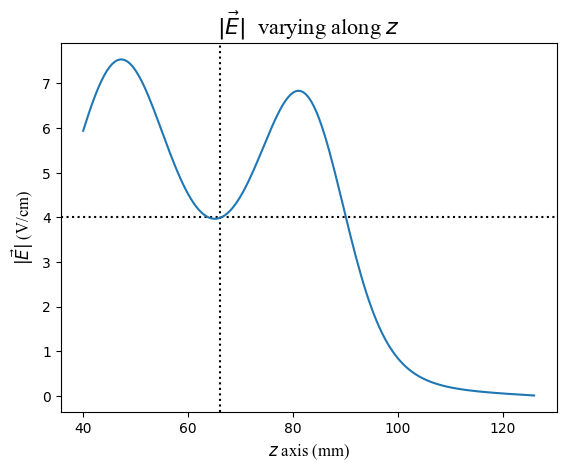

In [83]:
plt.axhline(y=4,linestyle='dotted',color='k')
plt.axvline(x=66,linestyle='dotted',color='k')
#plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("$z$ axis (mm)",fontproperties=font,fontsize=12)
plt.ylabel(r"$|\vec{E}|$ (V/cm)",fontproperties=font,fontsize=12)
plt.title(r"$|\vec{E}|$  varying along $z$",fontproperties=font,fontsize=16)


plt.plot(electrodes.z,abs_e_field[61,61,:],label=r'$|\vec{E}|$')
#plt.legend()

In [85]:
e_minus_45_along_d_prime=np.zeros(shape=(len(electrodes.x)))
for i in range(0,len(electrodes.x)):
    e_minus_45_along_d_prime[i]=(e_minus_45[i][i])
e_plus_45_along_d_prime=np.zeros(shape=(len(electrodes.x)))
for i in range(0,len(electrodes.x)):
    e_plus_45_along_d_prime[i]=(e_plus_45[i][i])

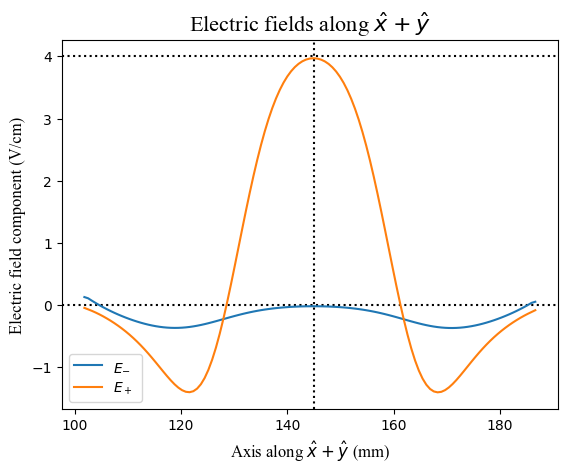

In [86]:
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=4,linestyle='dotted',color='k')
plt.xlabel("Axis along $\hat x + \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Electric fields along $\hat x + \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.x*np.sqrt(2),e_minus_45_along_d_prime,label='$E_{\minus}$')
plt.plot(electrodes.x*np.sqrt(2),e_plus_45_along_d_prime,label='$E_+$ ')
plt.legend()

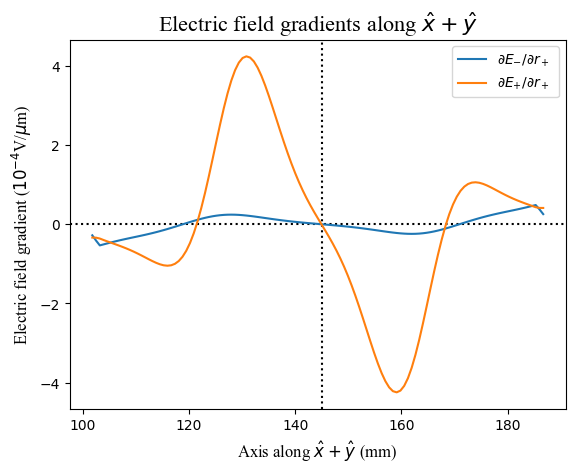

In [87]:
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("Axis along $\hat x + \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field gradient ($10^{-4}$V/$\mu$m)",fontproperties=font,fontsize=12)
plt.title("Electric field gradients along $\hat x + \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_minus_45_along_d_prime,0.05*np.sqrt(2)),label='$ \partial E_{\minus}/\partial r_+ $ ')
plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_plus_45_along_d_prime,0.05*np.sqrt(2)),label='$ \partial E_{\plus}/\partial r_+ $ ')
plt.legend()

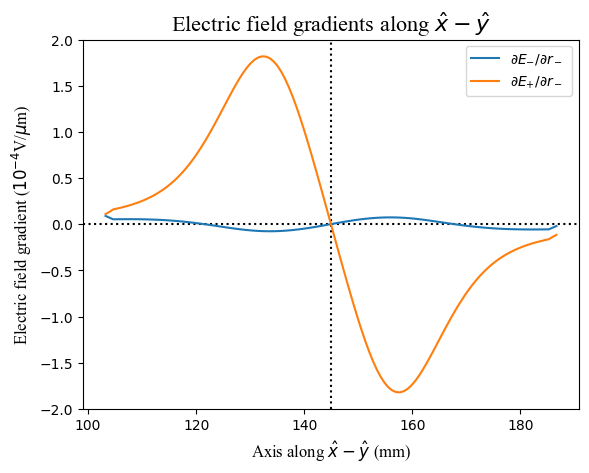

In [88]:
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("Axis along $\hat x - \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field gradient ($10^{-4}$V/$\mu$m)",fontproperties=font,fontsize=12)
plt.title("Electric field gradients along $\hat x - \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_minus_45_along_d,0.05*np.sqrt(2)),label='$ \partial E_{\minus}/\partial r_- $')
plt.plot(electrodes.x[2:]*np.sqrt(2),np.gradient(e_plus_45_along_d,0.05*np.sqrt(2)),label='$ \partial E_{\plus}/\partial r_- $ ')
plt.legend()

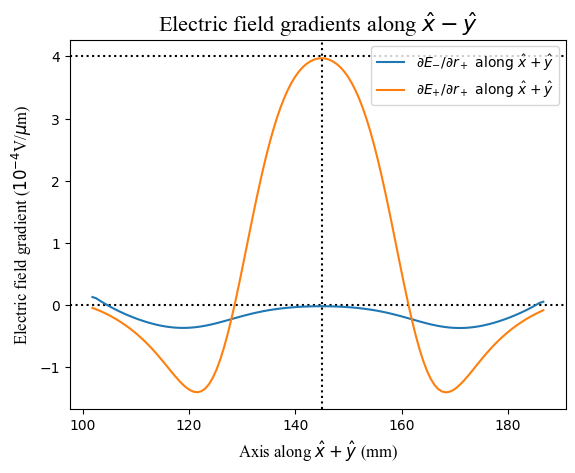

In [90]:
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.axhline(y=4,linestyle='dotted',color='k')

plt.xlabel("Axis along $\hat x + \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field gradient ($10^{-4}$V/$\mu$m)",fontproperties=font,fontsize=12)
plt.title("Electric field gradients along $\hat x - \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.x*np.sqrt(2),e_minus_45_along_d_prime,label='$ \partial E_{\minus}/\partial r_+ $ along $\hat x + \hat y$')
plt.plot(electrodes.x*np.sqrt(2),e_plus_45_along_d_prime,label='$ \partial E_{\plus}/\partial r_+ $ along $\hat x + \hat y$')
plt.legend()

In [240]:
e_plus_along_z=e_field_x[61,61,:]*np.cos(np.pi/4)+e_field_x[61,61,:]*np.sin(np.pi/4)
e_minus_along_z=e_field_x[61,61,:]*np.cos(-np.pi/4)+e_field_x[61,61,:]*np.sin(-np.pi/4)

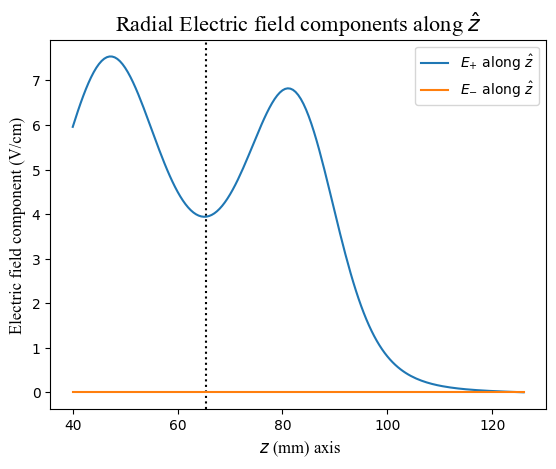

In [246]:

plt.axvline(x=65.5,linestyle='dotted',color='k')
#plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel(" $z$ (mm) axis",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Radial Electric field components along $\hat z $",fontproperties=font,fontsize=16)
plt.plot(electrodes.z,e_plus_along_z,label='$E_{\plus}$ along $\hat z$')


plt.plot(electrodes.z,e_minus_along_z,label='$E_{\minus}$ along $\hat z$')
plt.legend()

In [ ]:

plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted',color='k')
plt.axhline(y=0,linestyle='dotted',color='k')
plt.xlabel("Axis along $\hat x + \hat y$ (mm)",fontproperties=font,fontsize=12)
plt.ylabel("Electric field component (V/cm)",fontproperties=font,fontsize=12)
plt.title("Electric fields along $\hat x + \hat y$",fontproperties=font,fontsize=16)


plt.plot(electrodes.z,e_minus_45_along_d_prime,label='$E_{\minus}$ along $\hat x + \hat y$')
plt.plot(electrodes.x*np.sqrt(2),e_plus_45_along_d_prime,label='$E_+$ along $\hat x + \hat y$')
plt.legend()

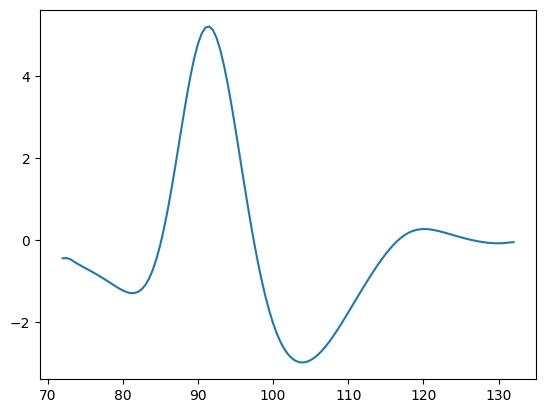

In [189]:
plt.plot(electrodes.x,np.gradient(e_along_diagonal_along_d,np.sqrt(2)*0.05))

Text(0.5, 0, 'y axis')

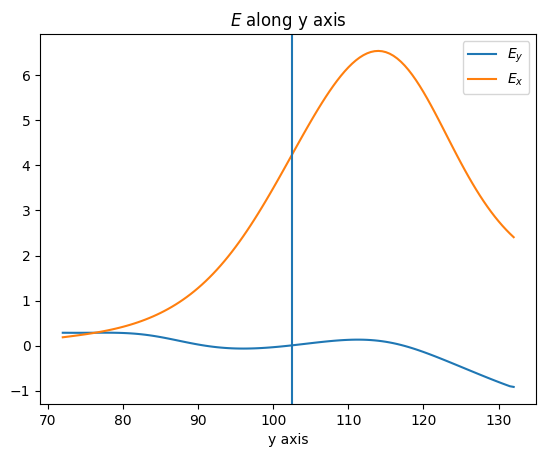

In [190]:
plt.plot(electrodes.y,e_field_y[61,:,51],label='$E_y$')
plt.plot(electrodes.y,e_field_x[61,:,51],label='$E_x$')
plt.axvline(x=102.5)
plt.legend()
plt.title("$E$ along y axis")
plt.xlabel("y axis")

Text(0.5, 0, 'x axis')

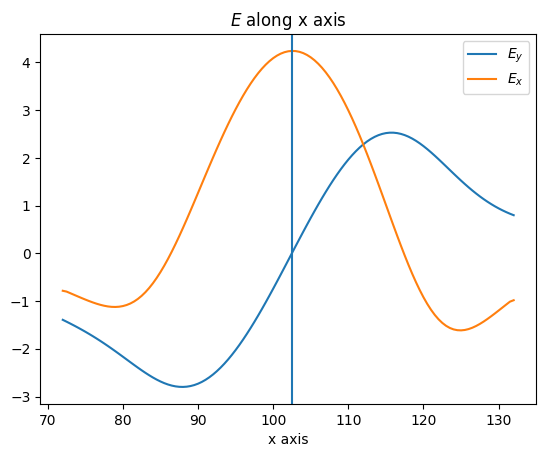

In [191]:
plt.plot(electrodes.x,e_field_y[:,61,51],label='$E_y$')
plt.plot(electrodes.x,e_field_x[:,61,51],label='$E_x$')
plt.axvline(x=102.5)
plt.legend()
plt.title("$E$ along x axis")
plt.xlabel("x axis")

Text(0, 0.5, '$E_x$')

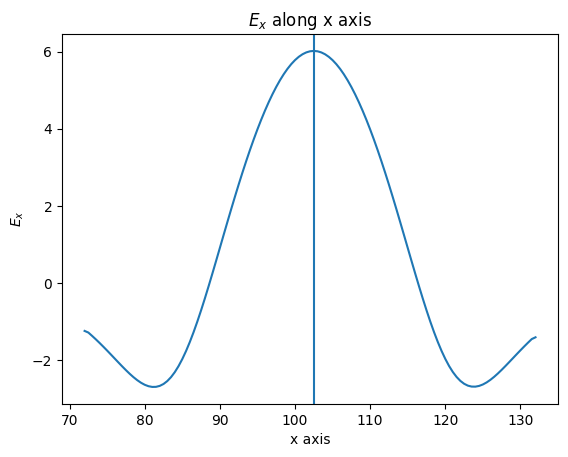

In [173]:
plt.plot(electrodes.x,np.gradient(e_field_y[:,61,51],0.05))
plt.axvline(x=102.5)
plt.title("$E_x$ along x axis")
plt.xlabel("x axis")
plt.ylabel('$E_x$')

Text(0, 0.5, '$\\partial E_x/\\partial y$')

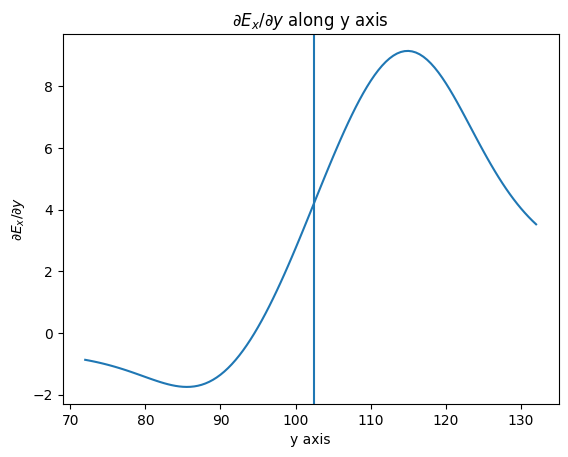

In [159]:
plt.plot(electrodes.x,np.gradient(e_field_x[:,61,51])
plt.axvline(x=102.5)
plt.title(r"$\partial E_x/\partial y$ along y axis")
plt.xlabel("y axis")
plt.ylabel('$\partial E_x/\partial y$')

In [126]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')


C:\Users\REET\AppData\Local\Temp\ipykernel_13216\1339965676.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


(-3.0, 3.0)

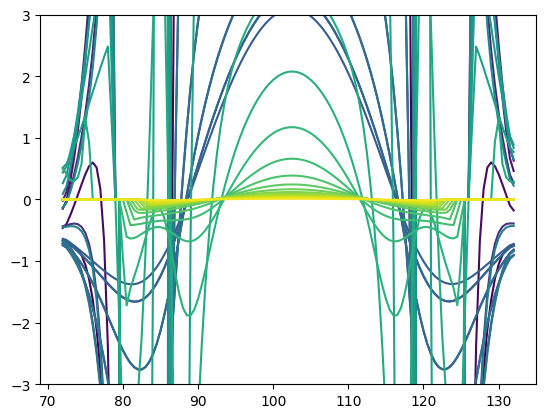

In [132]:
for i in range(0,len(electrodes.z),5):
    plt.plot(electrodes.x,np.gradient(e_field_y[:,61,i],0.05),color=cmap(i/len(electrodes.z)))
plt.ylim(-3,3)
 

In [ ]:
plt.plot()

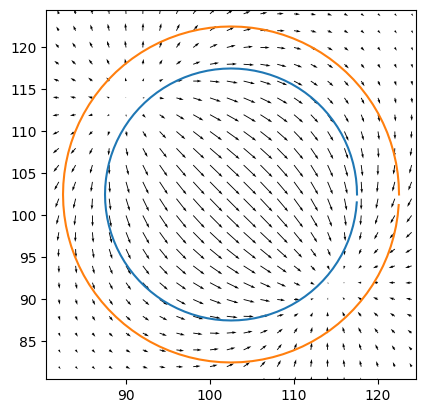

In [11]:

#x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
#plt.xlim(95,115)
#plt.ylim(95,115)
#plt.tight_layout()
plt.plot(electrode_coords_inner[:,0],electrode_coords_inner[:,1])

plt.plot(electrode_coords_outer[:,0],electrode_coords_outer[:,1])

#plt.plot(electrode_coords_outer_up[:,0],electrode_coords_outer_up[:,1])
plt.axis('square')
plt.quiver(x,y,np.transpose(e_x),np.transpose(e_y),scale=None)
plt.show()

In [11]:
17*14

238

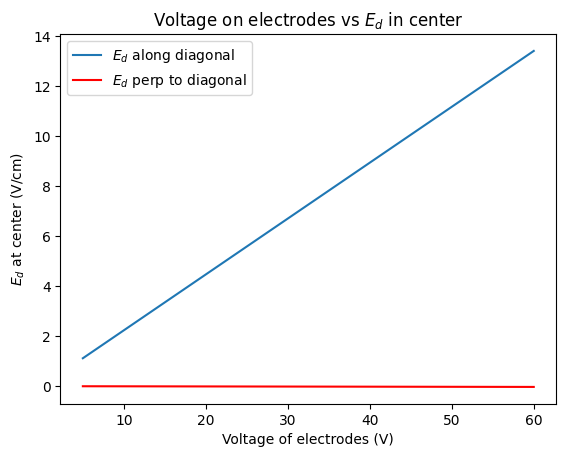

In [46]:
plt.plot(const_potentials,e_along_line_iter[:,61],label='$E_{d}$ along diagonal')
plt.plot(const_potentials,e_perp_line_iter[:,61],'r',label='$E_{d}$ perp to diagonal')
plt.title("Voltage on electrodes vs $E_{d}$ in center")
plt.xlabel("Voltage of electrodes (V)")
plt.ylabel("$E_{d}$ at center (V/cm)")
plt.legend()
plt.show()

#



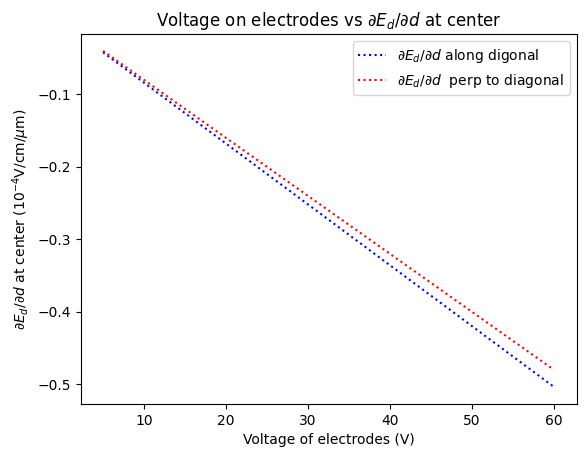

In [47]:
plt.plot(const_potentials,e_grad_along_line_iter[:,61],'b:',label='$\partial E_{d} / \partial d$ along digonal')
plt.plot(const_potentials,e_grad_perp_line_iter[:,61],'r:',label='$\partial E_{d} / \partial d$  perp to diagonal')
plt.title("Voltage on electrodes vs $\partial E_{d} / \partial d$ at center")
plt.xlabel("Voltage of electrodes (V)")
plt.ylabel("$\partial E_{d} / \partial d$ at center ($10^{-4}$V/cm/$\mu$m)")
plt.legend()
plt.show()


In [ ]:
fig, ax1 = plt.subplots()

#color = 'tab:red'
ax1.set_xlabel("Voltage of electrodes (V)")
ax1.set_ylabel("$E_{d}$ at center (V/cm)")
ax1.plot(const_potentials,e_along_line_iter[:,61],label='$E_{d}$ along diagonal', color="red")
ax1.plot(const_potentials,e_perp_line_iter[:,61],label='$E_{d}$ perp to diagonal',color="red",linestyle=':')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(bbox_to_anchor=(0.3,0.4))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
ax2.set_ylabel("$\partial E_{d} / \partial d$ at center (V/cm)")  # we already handled the x-label with ax1
ax2.plot(const_potentials,e_grad_along_line_iter[:,61],label='$\partial E_{d} / \partial d$ along digonal',color='blue')
ax2.plot(const_potentials,e_grad_perp_line_iter[:,61],label='$\partial E_{d} / \partial d$  perp to diagonal',color='blue',linestyle=':')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [98]:
def line(x,m,c):
    return x*m+c
m_c,variance=curve_fit(line, const_potentials,e_along_line_iter[:,61] )#bounds=(0, [3., 1., 0.5]))

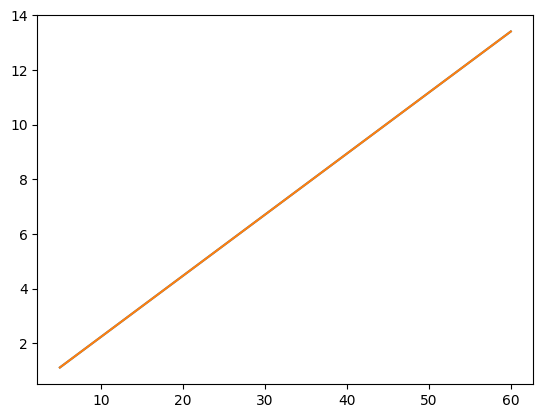

In [100]:
plt.plot(const_potentials,line(const_potentials,m_c[0],m_c[1]))
plt.plot(const_potentials,e_along_line_iter[:,61],label='along chosen direction')

In [101]:
e_field_required=3
potential_required=(e_field_required-m_c[1])/m_c[0]
print(potential_required)

13.426919428726753


In [22]:
theta_line_with_x = -np.pi/4
e_field_along_chosen_line=np.cos(theta_line_with_x)*e_field_x + np.sin(theta_line_with_x)*e_field_y 
e_field_perp_chosen_line=np.cos(np.pi/2+theta_line_with_x)*e_field_x + np.sin(np.pi/2+theta_line_with_x)*e_field_y 

In [23]:
e_along_line=np.zeros(shape=(len(electrodes.x),))
for i in range(len(electrodes.x)):
    e_along_line[i]=e_field_along_chosen_line[120-i,i,z_coord]

e_perp_line=np.zeros(shape=(len(electrodes.x),))
for i in range(len(electrodes.x)):
    e_perp_line[i]=e_field_perp_chosen_line[120-i,i,z_coord]


3.00445416106306
0.0012579584267689015


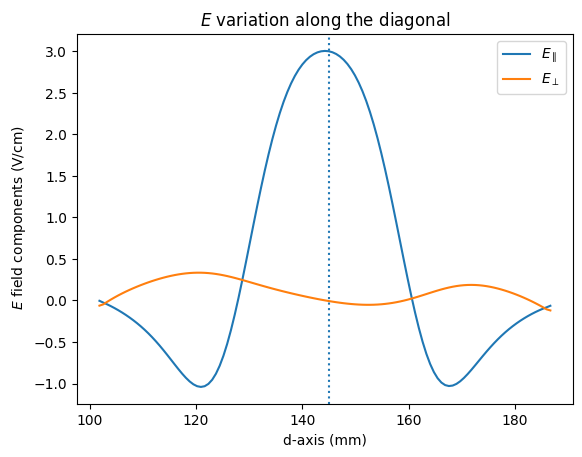

In [24]:

plt.plot(electrodes.x*np.sqrt(2),e_along_line,label='$E_{\parallel}$')
plt.plot(electrodes.x*np.sqrt(2),e_perp_line,label='$E_{\perp}$')
print(e_along_line[60])
print(e_perp_line[60])
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted')
plt.legend()

plt.title("$E$ variation along the diagonal")
plt.xlabel("d-axis (mm)")
plt.ylabel(" $E$ field components (V/cm)")

#plt.ylabel("$\partial E_{d} / \partial d$ ($10^{-4}$ V/cm/$\mu$m)")
plt.savefig('E_field_along_diag_const.png')

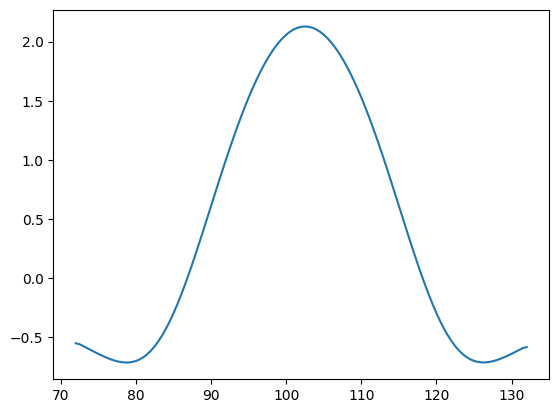

In [21]:
plt.plot(electrodes.x,e_field_x[:,61,51])


0.005651732823361598


Text(0, 0.5, '$\\partial E / \\partial d$ ($10^{-4}$ V/cm/$\\mu$m)')

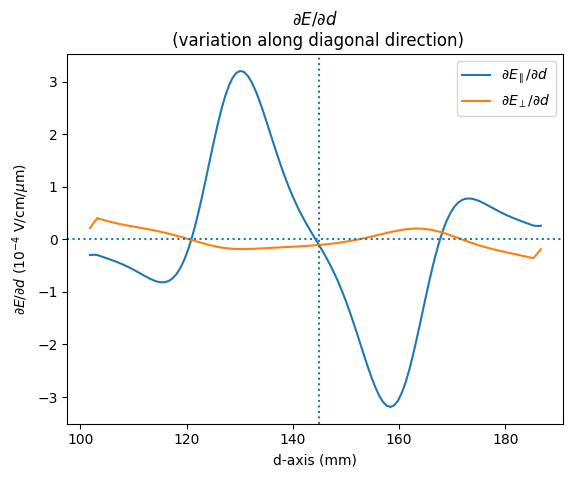

In [155]:
plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_along_line,np.sqrt(2)*0.05),label='$\partial E_{\parallel} / \partial d$')
plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_perp_line,np.sqrt(2)*0.05),label='$\partial E_{\perp} / \partial d$')
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted')
plt.axhline(y=0,linestyle='dotted')

print(np.gradient(e_along_line,np.sqrt(2)*0.05)[60])
plt.legend()
plt.title("$\partial E / \partial d$ \n (variation along diagonal direction)")
plt.xlabel("d-axis (mm)")
plt.ylabel("$\partial E / \partial d$ ($10^{-4}$ V/cm/$\mu$m)")

Text(0, 0.5, '$E_{z}$ (V/cm)')

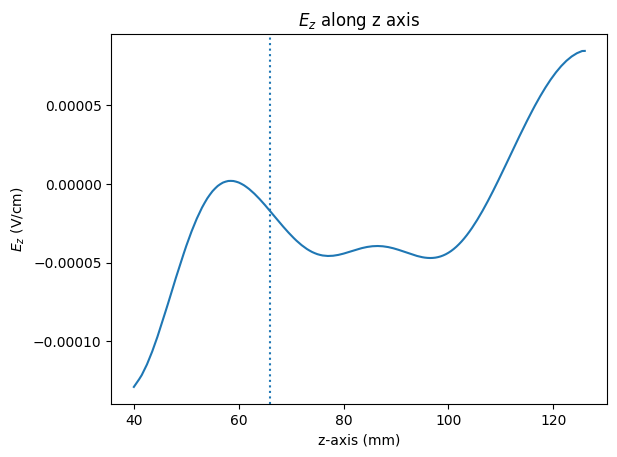

In [137]:
plt.plot(electrodes.z,e_field_z[61,61,:])
plt.axvline(x=66,linestyle='dotted')
plt.title("$E_{z}$ along z axis")
plt.xlabel("z-axis (mm)")
plt.ylabel("$E_{z}$ (V/cm)")

Text(0, 0.5, '$E_{\\parallel}$ (V/cm)')

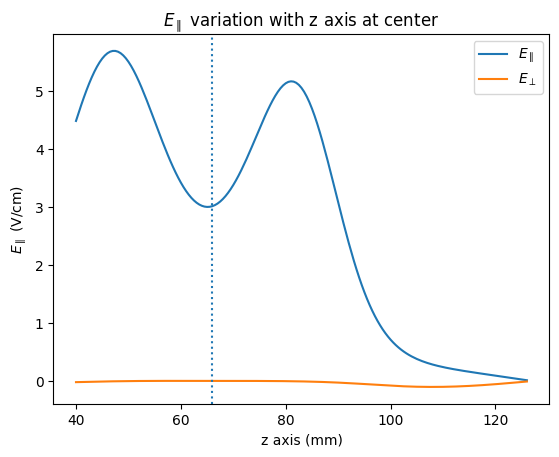

In [158]:
plt.title("$E_\parallel$ variation with z axis at center")
plt.plot(electrodes.z,e_field_along_chosen_line[61,61,:],label='$E_{\parallel}$')
plt.plot(electrodes.z,e_field_perp_chosen_line[61,61,:],label='$E_{\perp}$')
plt.legend()
plt.axvline(x=66,linestyle='dotted')
plt.xlabel("z axis (mm)")
plt.ylabel("$E_{\parallel}$ (V/cm)")

<xarray.DataArray 'x' ()>
array(102.5)
Coordinates:
    x        float64 102.5
-0.09127570667288865


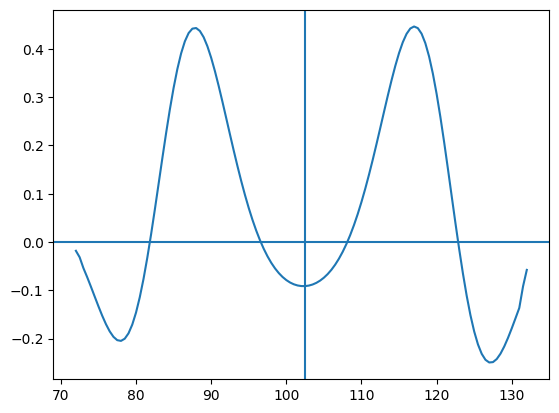

In [416]:
e_x_gradient=np.gradient(e_field_x[:,61,z_coord],0.05)
plt.plot(electrodes.x,e_x_gradient)
plt.axvline(x=102.5)
print(electrodes.x[61])
plt.axhline(y=0)
print(e_x_gradient[61])

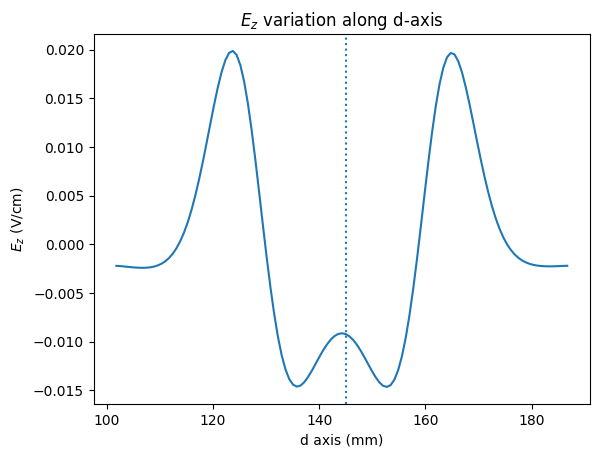

In [170]:
e_z_line=np.zeros(shape=(len(electrodes.x),))
for i in range(len(electrodes.x)):
    e_z_line[i]=e_field_z[120-i,i,z_coord]
plt.xlabel("d axis (mm)")
plt.ylabel("$E_{z}$ (V/cm)")

plt.title("$E_{z}$ variation along d-axis")
plt.plot(electrodes.x*np.sqrt(2),np.gradient(e_z_line))
plt.axvline(x=102.5*np.sqrt(2),linestyle='dotted')

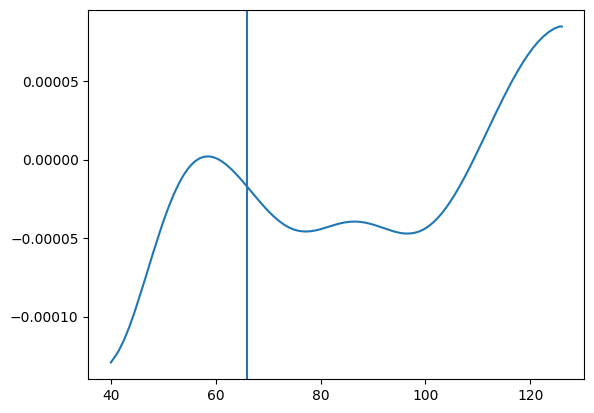

In [171]:
plt.plot(electrodes.z,e_field_z[61,61,:])
plt.axvline(x=66)

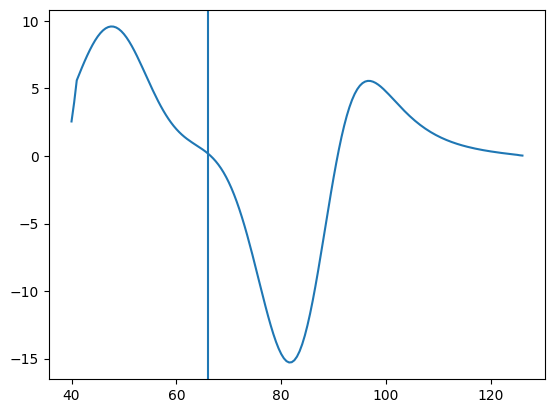

In [331]:
plt.plot(electrodes.z,np.gradient(e_field_z[61,61,:],0.05))
plt.axvline(x=66)

In [339]:
np.gradient(e_field_z[61,61,:],0.05)[51]

0.3443479290556972

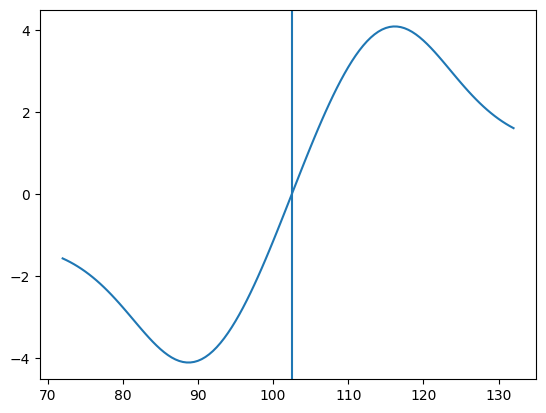

In [16]:
plt.plot(electrodes.y,e_field_x[61,:,z_coord])
plt.axvline(x=102.5)

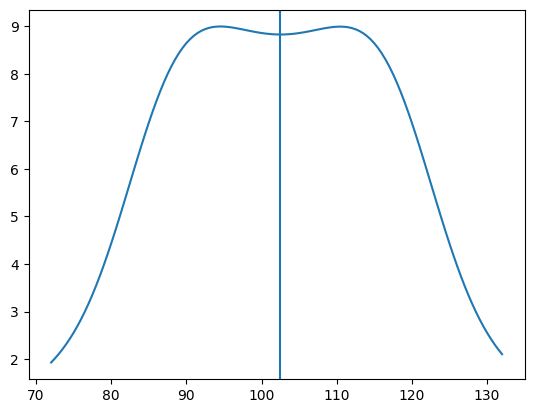

In [278]:
plt.plot(electrodes.x,e_field_z[:,61,z_coord])
plt.axvline(x=102.5)